# Libraries üìö

In [26]:
import random
import numpy as np
import easydict
from glob import glob
from natsort import natsorted
import os
from tqdm import tqdm
import pandas as pd
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import torch.utils.data as data
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
import math
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances

# Random seedüå±

In [27]:
#ÂÜçÁèæÊÄß„ÅÆÁ¢∫‰øù
seed = 44
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #Disabling the benchmark by CUDA convolution operation(GPU„Çí‰Ωø„ÅÜ„Å®„Åç„ÅÆÂÜçÁèæÊÄß„ÅÆÊãÖ‰øù) (https://pytorch.org/docs/stable/notes/randomness.html)
    torch.backends.cudnn.benchmark = False 
    torch.backends.cudnn.determinstic = True

# Arguments üìó

In [28]:
# ËâØ„ÅèÂ§â„Çè„ÇãÈ†ÖÁõÆ„ÅØ„Åì„Åì„Å´„Åæ„Å®„ÇÅ„Å¶Êõ∏„Åè
args = easydict.EasyDict({
    "data_path" : "test.csv", #Ê≠£Ëß£„É©„Éô„É´csv„Éï„Ç°„Ç§„É´
        
    "model_save_path" : "Checkpoints", # „É¢„Éá„É´‰øùÂ≠ò„Éá„Ç£„É¨„ÇØ„Éà„É™
    "model_file_name" : "model_data35000.pth", # „É¢„Éá„É´Âêç

    "result_save_path" : "result_model_data35000", # ÁµêÊûú‰øùÂ≠ò„Éá„Ç£„É¨„ÇØ„Éà„É™

    "data_size" : 5000 # „ÉÜ„Çπ„Éà„Éá„Éº„ÇøÊï∞
})

# Pre Procceing üéõ

In [29]:
def pre_procceing():
    """
    Âπ≥ÂùáÂÄ§ÔºåÊ®ôÊ∫ñÂÅèÂ∑Æ„ÇíÊ±Ç„ÇÅ„Çã

    Returns
    ----------
    mean : tuple
        „Éá„Éº„Çø„Çª„ÉÉ„Éà„ÅÆÁîªÁ¥†„ÅÆÂπ≥Âùá
    std : tuple
        „Éá„Éº„Çø„Çª„ÉÉ„Éà„ÅÆÁîªÁ¥†„ÅÆÊ®ôÊ∫ñÂÅèÂ∑Æ
    """
    df_ms = pd.read_csv(f"mean_std.csv")
    mean = df_ms["mean"][0]
    std = df_ms["std"][0]

    return mean, std

# Data set üß∞

In [30]:
class ImageTransform:
    """
    pytorch„Åß„ÅÆÁîªÂÉè„ÅÆÂâçÂá¶ÁêÜ„ÇØ„É©„Çπ
    Ë®ìÁ∑¥ÊôÇ„Å†„Åë„ÄÅ„Éá„Éº„Çø„Ç™„Éº„ÇÆ„É•„É°„É≥„ÉÜ„Éº„Ç∑„Éß„É≥(DA)„Åå„Åß„Åç„Çã„Çà„ÅÜ„Å´„ÄÅtrain,valid„ÅßÂàÜ„Åë„Å¶Êõ∏„ÅÑ„Åü

    Attributes
    ----------
    mean : int
        „Éá„Éº„Çø„Çª„ÉÉ„Éà„ÅÆÁîªÁ¥†ÂÄ§„ÅÆÂπ≥ÂùáÂÄ§
    std : int
        „Éá„Éº„Çø„Çª„ÉÉ„Éà„ÅÆÁîªÁ¥†ÂÄ§„ÅÆÊ®ôÊ∫ñÂÅèÂ∑Æ
    """   

    def __init__(self, mean, std):
        self.data_transform = {
            'train':transforms.Compose([
                #transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std) 
            ]),
            'valid':transforms.Compose([
                #transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    
    #ÂºïÊï∞„Å™„Åó„ÅßÂëº„Å∞„Çå„Åü„Å®„Åç„ÅÆÊåôÂãï„ÇíÂÆöÁæ©
    def __call__(self, img, phase='valid'):
        return self.data_transform[phase](img)

In [31]:
class Image_Dataset(data.Dataset):
    """
    ÁîªÂÉè„ÅÆ„Éá„Éº„Çø„Çª„ÉÉ„Éà„ÇØ„É©„Çπ„ÄÇ
    Pytorch Dataset class „ÇíÁ∂ôÊâø

    Attributes
    ----------
    df : DataFrame
        Â≠¶Áøí„Éá„Éº„Çø       
    transform : object
        class ImageTransform()    
    phase : str
        'train' or 'valid'
    """

    def __init__(self, df, transform, phase='train'):
        self.file_list = df["fname"] 
        self.labels = df[["dx","dy"]].to_numpy()
        self.l = df["l"]
        self.d = df["d"]
        self.transform = transform  
        self.phase = phase  

    #„Åì„ÅÆ„ÇØ„É©„Çπ„ÅÆÁîªÂÉèÊûöÊï∞„ÇíÂÆöÁæ©„ÄÇ
    def __len__(self):
        return len(self.file_list) 

    #„Åì„ÅÆ„ÇØ„É©„Çπ„Å´ËßíÊã¨Âºß„Åß„Ç¢„ÇØ„Çª„Çπ„Åó„ÅüÊôÇ„ÅÆÊåôÂãï„ÇíÂÆöÁæ©
    def __getitem__(self, index):
        # ÁîªÂÉè„Çí„É≠„Éº„Éâ
        img_path = self.file_list[index]
        img = Image.open(img_path)
        #img = img.convert("L") #„Ç∞„É¨„Ç§„Çπ„Ç±„Éº„É´ 
        # ÂâçÂá¶ÁêÜ
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([width, height]) 

        #label
        label = self.labels[index]
        #Tensor„Å´Â§âÊèõ
        label = torch.tensor(label, dtype=torch.float32) 

        # Á©∫Ê∞óÊè∫„Çâ„ÅéÈáè
        d = self.d[index]  

        # „ÉØ„Éº„Ç≠„É≥„Ç∞„Éá„Ç£„Çπ„Çø„É≥„Çπ
        l = self.l[index]         

        return img_transformed, label, d, l

# NetWork üß†

In [32]:
#„É¢„Éá„É´

# # ÊÆãÂ∑Æ„Éñ„É≠„ÉÉ„ÇØ
class block(nn.Module):
    def __init__(self, first_conv_in_channels, first_conv_out_channels, identity_conv=None, stride=1):
        """
        ÊÆãÂ∑Æ„Éñ„É≠„ÉÉ„ÇØ„Çí‰ΩúÊàê„Åô„Çã„ÇØ„É©„Çπ
        Args:
            first_conv_in_channels : 1Áï™ÁõÆ„ÅÆconvÂ±§Ôºà1√ó1Ôºâ„ÅÆinput channelÊï∞
            first_conv_out_channels : 1Áï™ÁõÆ„ÅÆconvÂ±§Ôºà1√ó1Ôºâ„ÅÆoutput channelÊï∞
            identity_conv : channelÊï∞Ë™øÊï¥Áî®„ÅÆconvÂ±§
            stride : 3√ó3convÂ±§„Å´„Åä„Åë„ÇãstideÊï∞„ÄÇsize„ÇíÂçäÂàÜ„Å´„Åó„Åü„ÅÑ„Å®„Åç„ÅØ2„Å´Ë®≠ÂÆö
        """        
        super(block, self).__init__()

        # 1Áï™ÁõÆ„ÅÆconvÂ±§Ôºà1√ó1Ôºâ
        self.conv1 = nn.Conv2d(first_conv_in_channels, first_conv_out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(first_conv_out_channels)

        # 2Áï™ÁõÆ„ÅÆconvÂ±§Ôºà3√ó3Ôºâ
        # „Éë„Çø„Éº„É≥3„ÅÆÊôÇ„ÅØsize„ÇíÂ§âÊõ¥„Åß„Åç„Çã„Çà„ÅÜ„Å´stride„ÅØÂèØÂ§â
        self.conv2 = nn.Conv2d(first_conv_out_channels, first_conv_out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(first_conv_out_channels)

        # 3Áï™ÁõÆ„ÅÆconvÂ±§Ôºà1√ó1Ôºâ
        # output channel„ÅØinput channel„ÅÆ4ÂÄç„Å´„Å™„Çã
        self.conv3 = nn.Conv2d(first_conv_out_channels, first_conv_out_channels*4, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(first_conv_out_channels*4)
        self.relu = nn.ReLU()

        # identity„ÅÆchannelÊï∞„ÅÆË™øÊï¥„ÅåÂøÖË¶Å„Å™Â†¥Âêà„ÅØconvÂ±§Ôºà1√ó1Ôºâ„ÇíÁî®ÊÑè„ÄÅ‰∏çË¶Å„Å™Â†¥Âêà„ÅØNone
        self.identity_conv = identity_conv


    def forward(self, x):

        identity = x.clone()  # ÂÖ•Âäõ„Çí‰øùÊåÅ„Åô„Çã

        x = self.conv1(x)  # 1√ó1„ÅÆÁï≥„ÅøËæº„Åø
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)  # 3√ó3„ÅÆÁï≥„ÅøËæº„ÅøÔºà„Éë„Çø„Éº„É≥3„ÅÆÊôÇ„ÅØstride„Åå2„Å´„Å™„Çã„Åü„ÇÅ„ÄÅ„Åì„Åì„Åßsize„ÅåÂçäÂàÜ„Å´„Å™„ÇãÔºâ
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)  # 1√ó1„ÅÆÁï≥„ÅøËæº„Åø
        x = self.bn3(x)

        # ÂøÖË¶Å„Å™Â†¥Âêà„ÅØconvÂ±§Ôºà1√ó1Ôºâ„ÇíÈÄö„Åó„Å¶identity„ÅÆchannelÊï∞„ÅÆË™øÊï¥„Åó„Å¶„Åã„ÇâË∂≥„Åô
        if self.identity_conv is not None:
            identity = self.identity_conv(identity)
        x += identity

        x = self.relu(x)

        return x
    
#  Resnet50
class ResNet(nn.Module):
    def __init__(self,block):
        """
        ResNet„ÇØ„É©„Çπ
        Args:
            block : ÊÆãÂ∑Æ„Éñ„É≠„ÉÉ„ÇØ
        """ 
        super(ResNet,self).__init__()

        # conv1„ÅØ„Ç¢„Éº„Ç≠„ÉÜ„ÇØ„ÉÅ„É£ÈÄö„Çä„Å´„Éô„ÇøÊâì„Å°
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # in:(64,112*112)„ÄÅout:(64,56*56)
        self.maxpool = nn.Identity()

        # conv2_x„ÅØ„Çµ„Ç§„Ç∫„ÅÆÂ§âÊõ¥„ÅØ‰∏çË¶Å„ÅÆ„Åü„ÇÅ„ÄÅstride„ÅØ1
        self.conv2_x = self._make_layer(block, 3, res_block_in_channels=64, first_conv_out_channels=64, stride=1)

        # conv3_x‰ª•Èôç„ÅØ„Çµ„Ç§„Ç∫„ÅÆÂ§âÊõ¥„Çí„Åô„ÇãÂøÖË¶Å„Åå„ÅÇ„Çã„Åü„ÇÅ„ÄÅstride„ÅØ2
        self.conv3_x = self._make_layer(block, 4, res_block_in_channels=256,  first_conv_out_channels=128, stride=2)
        self.conv4_x = self._make_layer(block, 6, res_block_in_channels=512,  first_conv_out_channels=256, stride=2)
        self.conv5_x = self._make_layer(block, 3, res_block_in_channels=1024, first_conv_out_channels=512, stride=2)

        #self.avgpool = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        # self.fc1 = nn.Linear(512*4,2)
        self.fc1 = nn.Identity()
    
        # mlp projection head
        self.projection = nn.Sequential(
            nn.Linear(in_features=2048, out_features=2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=128),
            nn.BatchNorm1d(128),
        )
        # Regression
        self.regression = nn.Sequential(
            nn.Linear(2048, 512), 
            nn.LeakyReLU(),       
            nn.Linear(512, 128),  
            nn.LeakyReLU(),
            nn.Linear(128, 32),        
            nn.Linear(32, 2)
        )

    def forward(self,x):

        x = self.conv1(x)  
        x = self.bn1(x)     
        x = self.relu(x)    
        x = self.maxpool(x) #out:(64*16*16)
        

        x = self.conv2_x(x)  # in:(64,56*56)  „ÄÅout:(256,56*56)
        x = self.conv3_x(x)  # in:(256,56*56) „ÄÅout:(512,28*28)
        x = self.conv4_x(x)  # in:(512,28*28) „ÄÅout:(1024,14*14)
        x = self.conv5_x(x)  # in:(1024,14*14)„ÄÅout:(2048,7*7)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1) # 2048
        x = self.fc1(x)
        #backbone_output = x.clone()

        projection_output = self.projection(x)
        regression_output = self.regression(x)

        return projection_output, regression_output

    def _make_layer(self, block, num_res_blocks, res_block_in_channels, first_conv_out_channels, stride):
        layers = []

        # 1„Å§ÁõÆ„ÅÆÊÆãÂ∑Æ„Éñ„É≠„ÉÉ„ÇØ„Åß„ÅØchannelË™øÊï¥„ÄÅÂèä„Å≥sizeË™øÊï¥„ÅåÁô∫Áîü„Åô„Çã
        # identify„ÇíË∂≥„ÅôÂâç„Å´1√ó1„ÅÆconvÂ±§„ÇíËøΩÂä†„Åó„ÄÅ„Çµ„Ç§„Ç∫Ë™øÊï¥„ÅåÂøÖË¶Å„Å™Â†¥Âêà„ÅØstride„Çí2„Å´Ë®≠ÂÆö
        identity_conv = nn.Conv2d(res_block_in_channels, first_conv_out_channels*4, kernel_size=1,stride=stride)
        layers.append(block(res_block_in_channels, first_conv_out_channels, identity_conv, stride))

        # 2„Å§ÁõÆ‰ª•Èôç„ÅÆinput_channelÊï∞„ÅØ1„Å§ÁõÆ„ÅÆoutput_channel„ÅÆ4ÂÄç
        in_channels = first_conv_out_channels*4

        # channelË™øÊï¥„ÄÅsizeË™øÊï¥„ÅØÁô∫Áîü„Åó„Å™„ÅÑ„Åü„ÇÅ„ÄÅidentity_conv„ÅØNone„ÄÅstride„ÅØ1
        for i in range(num_res_blocks - 1):
            layers.append(block(in_channels, first_conv_out_channels, identity_conv=None, stride=1))

        return nn.Sequential(*layers)

# Test & Evalation üßê

In [33]:
model = ResNet(block)
# load weights
model.load_state_dict(torch.load(os.path.join(args.model_save_path,args.model_file_name)))
model.eval()

test_df = pd.read_csv(args.data_path)
test_df = test_df[:args.data_size]

mean, std = pre_procceing()

transform = ImageTransform(mean, std)

test_dataset = Image_Dataset(df=test_df, transform=transform, phase='valid')
test_dataloader=torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    pin_memory=True,
    shuffle=False,
    )

# prediction for testdata
features = np.zeros((args.data_size, 128))
d_list = []
l_list = []

for i, minibatch in enumerate(tqdm(test_dataloader)):
    inputs, _, d, l = minibatch
    projection_output_, regression_output_ = model(inputs)
    features[i] = projection_output_.detach()
    d_list.append(d)
    l_list.append(l)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5000/5000 [26:56<00:00,  3.09it/s]


In [34]:
# ÁâπÂæ¥Èáè„Éû„ÉÉ„Éó‰øùÂ≠ò
os.makedirs(os.path.join(args.result_save_path),exist_ok=True)
np.save(os.path.join(args.result_save_path,"features.npy"), features)

In [35]:
# ÁâπÂæ¥Èáè„Éû„ÉÉ„Éó„É≠„Éº„Éâ
features = np.load(os.path.join(args.result_save_path,"features.npy"))
test_df = pd.read_csv(args.data_path)

In [36]:
# PCA„ÇíÈÅ©Áî®
pca = PCA(n_components=2)
images_pca = pca.fit_transform(features)
explained_variance_ratio = pca.explained_variance_ratio_

In [38]:
colorbar = "jet"

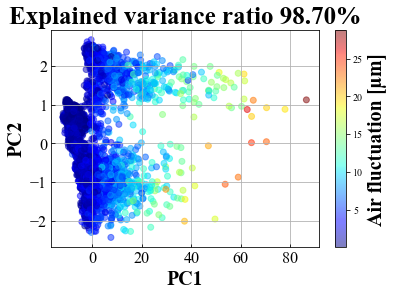

In [39]:
# Á©∫Ê∞óÊè∫„Çâ„ÅéÈáèpca
plt.rcParams['font.family'] = 'Times New Roman'
plt.tick_params(direction="in",labelsize=12) # Inward notation of scale
#plt.figure(figsize=(6, 6))
plt.scatter(images_pca[:, 0], images_pca[:, 1], alpha=0.5, c=test_df["d"][:args.data_size], cmap=colorbar)
cbar = plt.colorbar()
cbar.set_label('Air fluctuation [¬µm]', fontsize=20,weight="bold")
plt.grid()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("PC1", fontsize=20,weight="bold")
plt.ylabel("PC2", fontsize=20,weight="bold")
plt.title("Explained variance ratio {:.2f}%".format(np.sum(explained_variance_ratio)*100), fontsize=25,weight="bold")
plt.savefig(os.path.join(args.result_save_path,f'd_pca.png'), bbox_inches='tight')
plt.show()

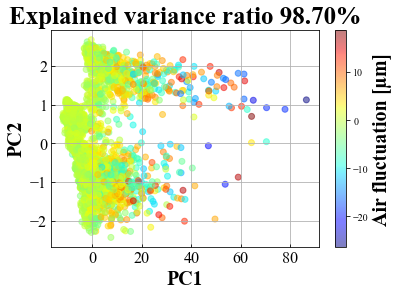

In [40]:
# X
plt.rcParams['font.family'] = 'Times New Roman'
plt.tick_params(direction="in",labelsize=12) # Inward notation of scale
#plt.figure(figsize=(6, 6))
plt.scatter(images_pca[:, 0], images_pca[:, 1], alpha=0.5, c=test_df["dx"][:args.data_size], cmap=colorbar)
cbar = plt.colorbar()
cbar.set_label('Air fluctuation [¬µm]', fontsize=20,weight="bold")
plt.grid()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("PC1", fontsize=20,weight="bold")
plt.ylabel("PC2", fontsize=20,weight="bold")
plt.title("Explained variance ratio {:.2f}%".format(np.sum(explained_variance_ratio)*100), fontsize=25,weight="bold")
plt.savefig(os.path.join(args.result_save_path,f'x_pca.png'), bbox_inches='tight')
plt.show()

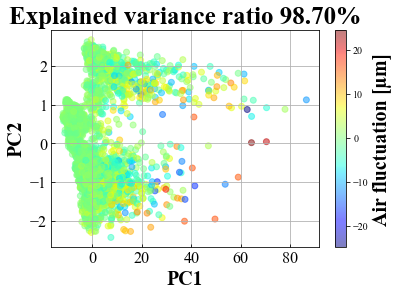

In [41]:
# Y
plt.rcParams['font.family'] = 'Times New Roman'
plt.tick_params(direction="in",labelsize=12) # Inward notation of scale
#plt.figure(figsize=(6, 6))
plt.scatter(images_pca[:, 0], images_pca[:, 1], alpha=0.5, c=test_df["dy"][:args.data_size], cmap=colorbar)
cbar = plt.colorbar()
cbar.set_label('Air fluctuation [¬µm]', fontsize=20,weight="bold")
plt.grid()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("PC1", fontsize=20,weight="bold")
plt.ylabel("PC2", fontsize=20,weight="bold")
plt.title("Explained variance ratio {:.2f}%".format(np.sum(explained_variance_ratio)*100), fontsize=25,weight="bold")
plt.savefig(os.path.join(args.result_save_path,f'y_pca.png'), bbox_inches='tight')
plt.show()

c:\Users\Aketa\anaconda3\envs\env_pytorch\lib\site-packages\matplotlib\axes\_axes.py:4186: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  c = np.asanyarray(c, dtype=float)


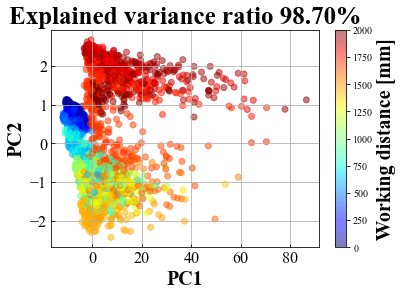

In [42]:
# WD
plt.rcParams['font.family'] = 'Times New Roman'
plt.tick_params(direction="in",labelsize=12) # Inward notation of scale
#plt.figure(figsize=(6, 6))
plt.scatter(images_pca[:, 0], images_pca[:, 1], alpha=0.5, c=l_list, cmap=colorbar)
cbar = plt.colorbar()
cbar.set_label('Working distance [mm]', fontsize=20,weight="bold")
plt.grid()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("PC1", fontsize=20,weight="bold")
plt.ylabel("PC2", fontsize=20,weight="bold")
plt.title("Explained variance ratio {:.2f}%".format(np.sum(explained_variance_ratio)*100), fontsize=25,weight="bold")
plt.savefig(os.path.join(args.result_save_path,f'l_pca.png'), bbox_inches='tight')
plt.show()

# 5000ÂÄãÁÇπ„ÅÇ„Çã„Å®Ë¶ã„Å•„Çâ„ÅÑ„ÅÆ„Åß1000ÂÄã„Éê„Éº„Ç∏„Éß„É≥

In [43]:
images_pca = images_pca[:1000]

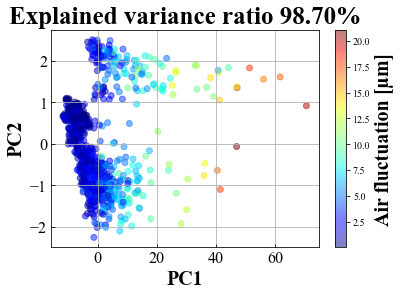

In [44]:
# Á©∫Ê∞óÊè∫„Çâ„ÅéÈáèpca
plt.rcParams['font.family'] = 'Times New Roman'
plt.tick_params(direction="in",labelsize=12) # Inward notation of scale
#plt.figure(figsize=(6, 6))
plt.scatter(images_pca[:, 0], images_pca[:, 1], alpha=0.5, c=test_df["d"][:1000], cmap=colorbar)
cbar = plt.colorbar()
cbar.set_label('Air fluctuation [¬µm]', fontsize=20,weight="bold")
plt.grid()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("PC1", fontsize=20,weight="bold")
plt.ylabel("PC2", fontsize=20,weight="bold")
plt.title("Explained variance ratio {:.2f}%".format(np.sum(explained_variance_ratio)*100), fontsize=25,weight="bold")
plt.savefig(os.path.join(args.result_save_path,f'd_pca_1000plot.png'), bbox_inches='tight')
plt.show()

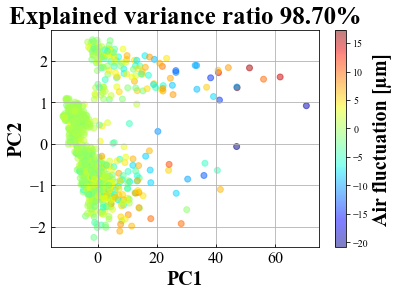

In [45]:
# X
plt.rcParams['font.family'] = 'Times New Roman'
plt.tick_params(direction="in",labelsize=12) # Inward notation of scale
#plt.figure(figsize=(6, 6))
plt.scatter(images_pca[:, 0], images_pca[:, 1], alpha=0.5, c=test_df["dx"][:1000], cmap=colorbar)
cbar = plt.colorbar()
cbar.set_label('Air fluctuation [¬µm]', fontsize=20,weight="bold")
plt.grid()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("PC1", fontsize=20,weight="bold")
plt.ylabel("PC2", fontsize=20,weight="bold")
plt.title("Explained variance ratio {:.2f}%".format(np.sum(explained_variance_ratio)*100), fontsize=25,weight="bold")
plt.savefig(os.path.join(args.result_save_path,f'x_pca_1000plot.png'), bbox_inches='tight')
plt.show()

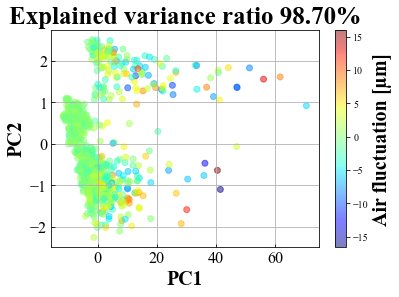

In [46]:
# Y
plt.rcParams['font.family'] = 'Times New Roman'
plt.tick_params(direction="in",labelsize=12) # Inward notation of scale
#plt.figure(figsize=(6, 6))
plt.scatter(images_pca[:, 0], images_pca[:, 1], alpha=0.5, c=test_df["dy"][:1000], cmap=colorbar)
cbar = plt.colorbar()
cbar.set_label('Air fluctuation [¬µm]', fontsize=20,weight="bold")
plt.grid()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("PC1", fontsize=20,weight="bold")
plt.ylabel("PC2", fontsize=20,weight="bold")
plt.title("Explained variance ratio {:.2f}%".format(np.sum(explained_variance_ratio)*100), fontsize=25,weight="bold")
plt.savefig(os.path.join(args.result_save_path,f'y_pca_1000plot.png'), bbox_inches='tight')
plt.show()

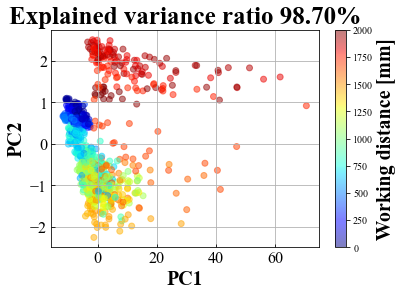

In [47]:
# WD
plt.rcParams['font.family'] = 'Times New Roman'
plt.tick_params(direction="in",labelsize=12) # Inward notation of scale
#plt.figure(figsize=(6, 6))
plt.scatter(images_pca[:, 0], images_pca[:, 1], alpha=0.5, c=test_df["l"][:1000], cmap=colorbar)
cbar = plt.colorbar()
cbar.set_label('Working distance [mm]', fontsize=20,weight="bold")
plt.grid()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("PC1", fontsize=20,weight="bold")
plt.ylabel("PC2", fontsize=20,weight="bold")
plt.title("Explained variance ratio {:.2f}%".format(np.sum(explained_variance_ratio)*100), fontsize=25,weight="bold")
plt.savefig(os.path.join(args.result_save_path,f'l_pca_1000plot.png'), bbox_inches='tight')
plt.show()